# Complete graph

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def py_dir(filename):
    return "./MST_O_logn_logn/" + filename 
    
def cpp_dir(filename):
    return "./MST_O_logn_logn_C-/" + filename 

# 1. Optimization

## Python memory usage

The size of the full graph is $8n^2$, given that each float64 takes 8 bytes in Numpy. Locally, for holding the graph, each machine locally needs
$$
  \frac{8n^2}{m}
$$
Bytes.
However, the most memory eager construction is the sendbuf during the first step, where each vertex sends edges pointing to other clusters to their cluster leaders. During the first round of the algorithm, each vertex is sending an edge to all the other vertices for the step 1 in the algorithm. Each ClusterEdge instance is a tuple with 3 elements (vertex_from, vertex_to, weight) sized 64 bytes. To send that, each machine needs to construct a buffer sized
$$
  \frac{64n^2}{m}
$$
Bytes During the first round of the original $A$. This is the most memory eager operation in the whole algorithm, 

## $A$ optimization on the first round

During the first round, each cluster has size 1 so what rank 0 receives at the end of the iteration is the minimum edge from each vertex. We can skip step 1-3 by sending the minimum edge from each vertex to rank 0 directly.

## pre-optimization vs post-optimizationd

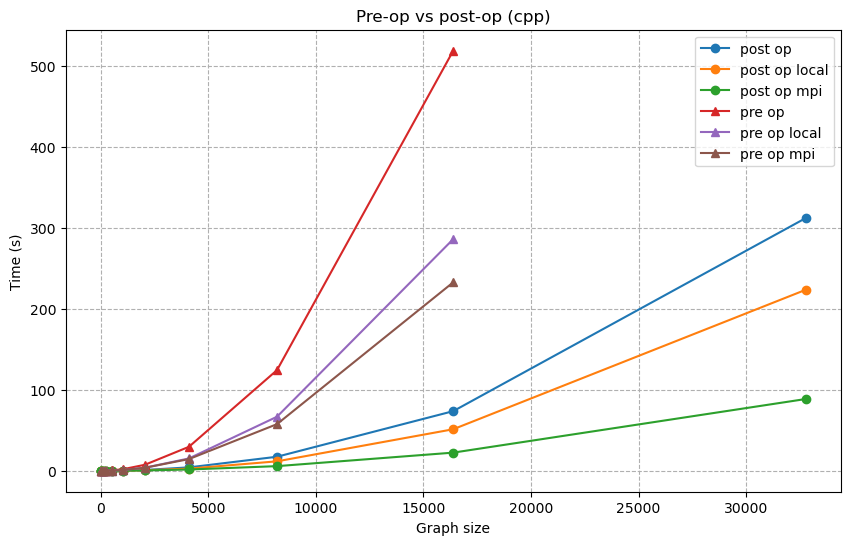

In [2]:
df_mpi_8 = pd.read_csv(cpp_dir('dist_n1_t8.csv'))
df_mpi_8_original = pd.read_csv(cpp_dir('dist_n1_t8_original.csv'))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_mpi_8['num_vertices'], df_mpi_8['t_mpi'], label="post op", marker='o')
plt.plot(df_mpi_8['num_vertices'], df_mpi_8['t_mpi_local'], label="post op local", marker='o')
plt.plot(df_mpi_8['num_vertices'], df_mpi_8['t_mpi_mpi'], label="post op mpi", marker='o')
plt.plot(df_mpi_8_original['num_vertices'], df_mpi_8_original['t_mpi'], label="pre op", marker='^')
plt.plot(df_mpi_8_original['num_vertices'], df_mpi_8_original['t_mpi_local'], label="pre op local", marker='^')
plt.plot(df_mpi_8_original['num_vertices'], df_mpi_8_original['t_mpi_mpi'], label="pre op mpi", marker='^')

plt.xlabel('Graph size')
plt.ylabel('Time (s)')
plt.title("Pre-op vs post-op (cpp)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

## Running time factor

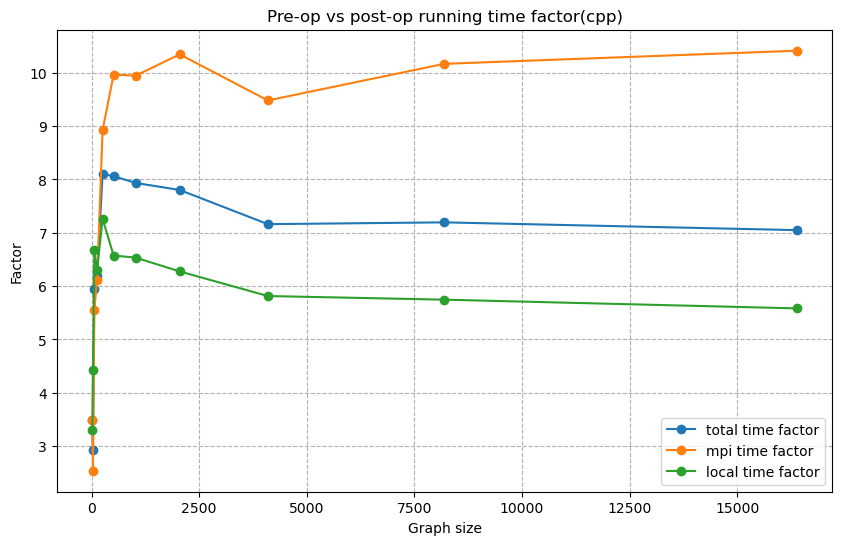

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df_mpi_8['num_vertices'], df_mpi_8_original['t_mpi'] / df_mpi_8['t_mpi'], label="total time factor", marker='o')
plt.plot(df_mpi_8['num_vertices'], df_mpi_8_original['t_mpi_mpi'] / df_mpi_8['t_mpi_mpi'] , label="mpi time factor", marker='o')
plt.plot(df_mpi_8['num_vertices'], df_mpi_8_original['t_mpi_local'] / df_mpi_8['t_mpi_local'] , label="local time factor", marker='o')


plt.xlabel('Graph size')
plt.ylabel('Factor')
plt.title("Pre-op vs post-op running time factor(cpp)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

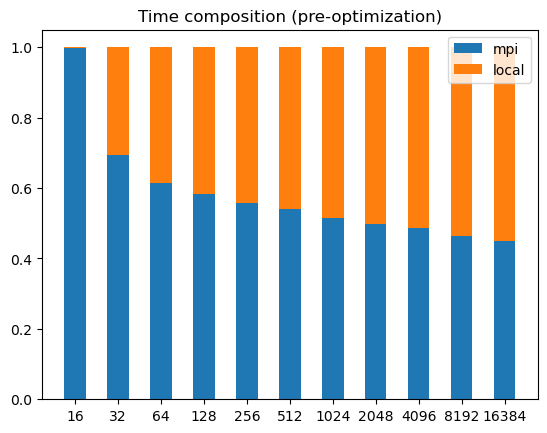

In [36]:
width = 0.5

fig, ax = plt.subplots()

mpi_fractions = df_mpi_8_original['t_mpi_mpi'] / df_mpi_8_original['t_mpi']
local_fractions = df_mpi_8_original['t_mpi_local'] / df_mpi_8_original['t_mpi']

x = tuple([str(i) for i in df_mpi_8_original['num_vertices']])

p = ax.bar(x, mpi_fractions, width, label="mpi")
p = ax.bar(x, local_fractions, width, label="local", bottom=mpi_fractions)

ax.set_title("Time composition (pre-optimization)")
ax.legend(loc="upper right")

plt.show()

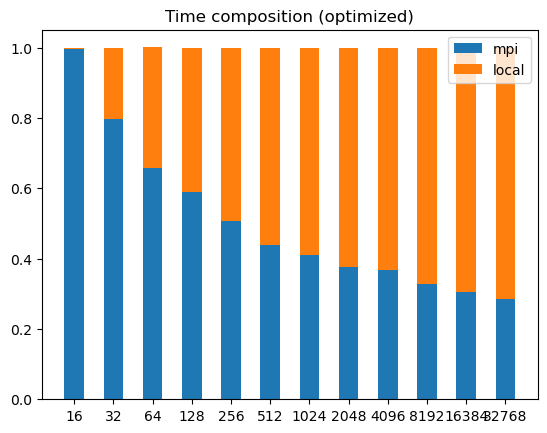

In [34]:
width = 0.5

fig, ax = plt.subplots()

mpi_fractions = df_mpi_8['t_mpi_mpi'] / df_mpi_8['t_mpi']
local_fractions = df_mpi_8['t_mpi_local'] / df_mpi_8['t_mpi']

x = tuple([str(i) for i in df_mpi_8['num_vertices']])

p = ax.bar(x, mpi_fractions, width, label="mpi")
p = ax.bar(x, local_fractions, width, label="local", bottom=mpi_fractions)

ax.set_title("Time composition (optimized)")
ax.legend(loc="upper right")

plt.show()

The optimized $A$ is roughly 7 times faster than the original version. The speed up for MPI is around 10 times but for local it's around 6. The speed up for MPI is bigger.

This optimization on the first round cuts away the need to do mpi.alltoall on the whole graph and looping through every edge during the first round. Before the optimization, MPI time was dominant, which means that transfering the whole graph with MPI.alltoall is the most time consuming process.

In the congested clique model, such an action takes only one communication round. But flooding the network does not work well with reallife MPC. The algorithm is exploiting the badwidth luxury of the congested clique model. Taking such a step away from the algorithm bring 10 times speed up of the total MPI time. 

# 2. $O(\log{n})$ Bandwidth

In the step 2(b) and 3 of the algorithm, it tries to collect every min edge to the leader node (rank 0). Instead of sending the edges from each cluster leader to the leader node, they spread the edges to each cluster member and send to the leader node from the cluster members.

They did it this way to overcome the bandwidth limit of the congested clique model. For exmaple, if they send the edge directly from the cluster leader to the leader node, it breaks the bandwidth limit of $O(\log{n})$ bits.

Below shows the the original algo communication time, comm2 is the time used to distributing the edges to guadians, comm3 is the time used for rank 0 to collect from each guardians

In [42]:
df = pd.read_csv(py_dir('strong_scaling/strong_scale_t8_4096.csv'))

df

,round,time (seconds),mpi time,comm0 time,comm1 time,comm2 time,comm3 time,comm4 time
0,1,0.333585,0.070200,0.04274,0.000000,0.000000,0.000000,0.027460
1,2,381.350939,221.134995,0.00000,96.770867,123.427897,0.805630,0.130600
2,3,155.257385,35.081683,0.00000,9.223262,25.790846,0.062349,0.005227


By removing the distributing to guardian part and collecting the edges to rank 0 directly from each cluster leaders, we obtain the following running time. comm3 is the time of collecting from cluster leaders to rank 0.

In [49]:
df = pd.read_csv(py_dir('strong_scaling/strong_scale_t8_4096_no_collect.csv'))

df

,round,time(seconds),mpitime,comm0time,comm1time,comm2time,comm3time,comm4time
0,1,0.329748,0.075136,0.046388,0.000000,0,0.000000,0.028748
1,2,411.215769,244.981943,0.000000,98.160743,0,146.680317,0.140883
2,3,174.502476,48.902774,0.000000,16.620431,0,32.276845,0.005497


We can see that there is no speed up by spliting the step into two steps. Even the first one fits the congested clique framework but it does not give any speedup benefit from the first one.